## Mise en oeuvre Numpy 

### Traitement de données avec Numpy 

Vous avez à disposition dans le `data/experiments` quatre fichiers de données expérimentales. L'objectif est de faire un programme utilisant massivement Numpy pour : 

1. Lire les 4 fichiers 
2. Nettoyer les données (notamment la présence de valeurs NaN)
3. Trouver la valeur max de la contrainte dans chaque fichier 
4. Calculer la moyenne des valeurs max 

Indication : en utilisant pleinement le potentiel de Numpy ces opérations peuvent se faire en 10 lignes de code. 

In [3]:
import pathlib as pl 
import numpy as np 
data_dir = pl.Path("data") / "experiments"

max_col1 = []
max_col2 = []
for fname in data_dir.glob("*.txt"):
    data = np.loadtxt( fname )
    ###mask = data[:,0] == data[:,0]
    data_clean = data[data[:,0] == data[:,0],:]
    if data_clean.shape[0] == 0:
        continue
    maxs = np.max(data_clean, axis=0)
    max_col1.append(maxs[0])
    max_col2.append(maxs[1])
print(f"mean max col1 : {np.mean(max_col1)}")
print(f"mean max col2 : {np.mean(max_col2)}")



mean max col1 : 0.11247466351165912
mean max col2 : 640.1075696782702


skip file data/experiments/data_1.txt
skip file data/experiments/data_2.txt
[701.0826484972805, 579.1324908592601]
moyenne : 640.1075696782702



## Compression d'image par SVD 

Dans ce premier exerice l'objectif est de compresser une image en niveau de gris en utilisant une SVD (Singular Value Decomposition). L'image à compresser est la suivante : 

![](data/carrie_fisher.png)

Pour rappel, la décomposition SVD d'une matrice $\mathbf{A} \in \mathbb{R}^{m\times n}$ s'écrit de la manière suivante : 

$$ \mathbf{A} = \mathbf{U}\cdot\mathbf{\Sigma}\cdot\mathbf{V} $$

Avec $\mathbf{U}\in \mathbb{R}^{m\times m}$, $\mathbf{\Sigma}\in\mathbb{R}^{m\times n}$ une matrice diagonale des valeurs singulière et $\mathbf{V} \in \mathbb{R}^{n\times n}$. 

**Question 1 :** 

Charger l'image de Carrie Fisher (vous trouverez dans le dossier data un fichier carrie_fisher.npy contenant l'image ous forme d'un np.ndarray) et calculer sa décomposition en valeurs singulière. 

**Question 2 :**

Tracer l'évolution des valeurs singulière de l'image. 

**Question 3 :**

Pour différentes troncatures ($k=\lbrace 1,5,10,15,20,30,50,100 \rbrace$) reconstruire l'image, l'afficher et calculer le taux de compression obtenues.  

In [10]:
### Question 1 
import numpy as np 
import pathlib as pl 

chemin = pl.Path(".") / "data" / "carrie_fisher.npy"
img = np.load( chemin )

print(f"Image shape : {img.shape}")

### Calcul de la SVD 
u,s,v = np.linalg.svd(img, full_matrices=False)

### Illustration SVD 
print(u.shape)
print(s.shape)
print(v.shape)
img_reconstruction = u @ np.diag(s) @ v 
if np.allclose(img_reconstruction, img):
    print("Ok l'image reconstruire est bien égale à l'image d'origine")


Image shape : (409, 670)
(409, 409)
(409,)
(409, 670)
Ok l'image reconstruire est bien égale à l'image d'origine


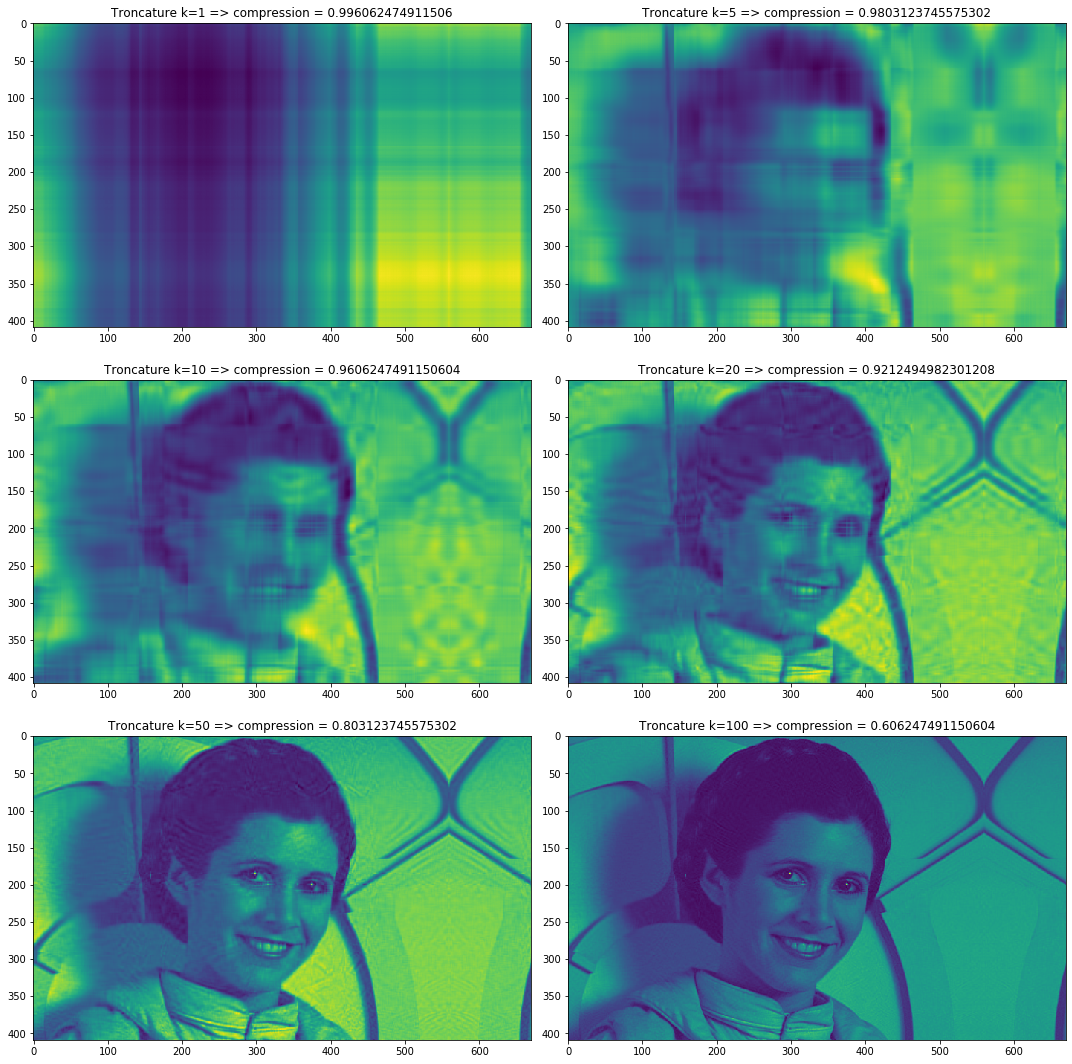

In [19]:
import matplotlib.pyplot as plt 
listTroncature = [1,5,10,20,50,100]

fig, axes = plt.subplots(3,2, figsize=(15,15))
axs = axes.ravel()

volume_init = img.shape[0]*img.shape[1]

for i, k in enumerate(listTroncature):
    u_r = u[:,:k]
    s_r = np.diag(s[:k])
    v_r = v[:k,:]
    img_compresse = u_r @ s_r @ v_r 
    volume_compresse = (img.shape[0] + img.shape[1]) * k 
    compression = (volume_init - volume_compresse) / volume_init
    axs[i].imshow( img_compresse )
    axs[i].set_title(f"Troncature k={k} => compression = {compression}")
    
fig.tight_layout()

## Résolution d'un système non-linéaire : méthode de Newton 

Considérons un système non-linéaire de deux équations à deux inconnues.




$$\mathcal{R}\left( x_1, x_2 \right) = \begin{cases}
  x_1^{2} + 2 x_1 x_2 &= 0 \\
  x_1 x_2 + 1           &= 0
 \end{cases}$$

Pour rappel la méthode de Newton permet de définir la suite suivante : 

$$ \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - D\left( \mathcal{R}( \mathbf{x}^{(k)} ) \right)^{-1} \cdot \mathcal{R}( \mathbf{x}^{(k)} ) $$

La notation $D\left( \mathcal{R}( \mathbf{x}^{(k)} )\right)$ symbolise le gradient (dérivée multidimensionnelle) de la fonctionnelle $\mathcal{R}$. Il s'agit donc de la matrice jacobienne de $\mathcal{R}$ évaluée en $\mathbf{x}^{(k)}$. Concrètement cette matrice jacobienne se définit, dans le cas d'un système de taille $n$, de la manière suivante : 

$$ \left[ D\left( \mathcal{R}( \mathbf{x}^{(k)} )\right) \right]_{ij} = \left. \frac{ \partial [ \mathcal{R} ]_{i} }{ \partial [\mathbf{x}]_{j} } \right\vert_{\mathbf{x}=\mathbf{x}^{(k)}} \;\;\; \forall (i,j) \in N,N$$

**Question 1 :**

Calculer la matrice Jacobienne de $\mathcal{R}$. 


**Question 2 :** 

Implémenter la méthode de Newton et résoudre le système d'équation. 

**Bonus :**

Proposer une méthode de résolution utilisant une approximation de la matrice jacobienne. 

In [21]:
#### Question 1 et 2
import numpy as np 

def f( x ):
    return np.array([[x[0,0]**2 + 2*x[0,0]*x[1,0]],[x[0,0]*x[1,0]+1]])

def df( x ):
    jac = np.zeros( (x.shape[0], x.shape[0]))
    jac[0,0] = 2*x[0,0] + 2*x[1,0]
    jac[0,1] = 2*x[0,0]
    jac[1,0] = x[1,0]
    jac[1,1] = x[0,0]
    return jac

n_iter_max = 100
x = 1. + np.zeros((2,1))
i = 0
while np.linalg.norm( f(x) ) > 1.e-9 and i < n_iter_max:
    jac = df(x)
    res = f(x)
    dx = np.linalg.solve( jac, res )
    x -= dx
    i += 1
    print("Ite {} => || f(x) || = {:.3e}".format(i, np.linalg.norm( f(x) )))

print("Solution is {}".format(x))

Ite 1 => || f(x) || = 2.574e+00
Ite 2 => || f(x) || = 1.336e-01
Ite 3 => || f(x) || = 2.293e-04
Ite 4 => || f(x) || = 3.434e-10
Solution is [[ 1.41421356]
 [-0.70710678]]
